# *Conexión al Drive*

In [ ]:
# prompt: crear conexion a drive

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


# *Librerias*

In [48]:
###paquete para crear y trabajar con bases de datos.
import sqlite3 as sql
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go ### para gráficos
import plotly.express as px
import a_funciones as fn
from mlxtend.preprocessing import TransactionEncoder
import re
import shutil
import os
import sys

ModuleNotFoundError: No module named 'a_funciones'

# *Creación de una copia de la base de datos original*

In [ ]:
path='/content/drive/MyDrive/cod/marketing/MarketingprojectG8/data'
os.chdir(path)###volver la carpeta del repositorio directorio de trabajo
sys.path.append(path)### agregarla al path, para poder leer los archivos de funciones propios como paquetes

# Ruta de la base de datos copiada (new database file path)
copied_path = '/content/drive/MyDrive/cod/marketing/MarketingprojectG8/data/movies2'

# Construcción la ruta completa al archivo de base de datos de origen
source_file = os.path.join(path, 'db_movies')

# Crear una copia de la base de datos
shutil.copy(source_file, copied_path)

# Verificar que se haya copiado la base de datos
print(f"Database copied from '{source_file}' to '{copied_path}'")

Database copied from '/content/drive/MyDrive/cod/marketing/MarketingprojectG8/data/db_movies' to '/content/drive/MyDrive/cod/marketing/MarketingprojectG8/data/movies2'


### *Conexión a SQL*

In [ ]:
# Conectar a la nueva base de datos copiada
con = sql.connect(copied_path)
cur= con.cursor()

# Consultar las tablas para verificar que la copia se realizó correctamente
cur.execute("SELECT name FROM sqlite_master WHERE type='table';")
tables = cur.fetchall()

print("Tablas en la base de datos copiada:")
for table in tables:
    print(table)

Tablas en la base de datos copiada:
('ratings',)
('movies',)


### *Cargar las tablas en DataFrames*

In [ ]:
# Cargar tabla movies
cur.execute('SELECT * FROM movies')
movies_data = cur.fetchall()
movies_columns = [description[0] for description in cur.description]  # Obtener nombres de columnas
movies_df = pd.DataFrame(movies_data, columns=movies_columns)

# Mostrar las primeras filas de la tabla
movies_df.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [ ]:
# Cargar tabla ratings
cur.execute('SELECT * FROM ratings')
ratings_data = cur.fetchall()
ratings_columns = [description[0] for description in cur.description]  # Obtener nombres de columnas
ratings_df = pd.DataFrame(ratings_data, columns=ratings_columns)

# Mostrar las primeras filas de la tabla
ratings_df.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


## *Nueva Tabla Movies*





In [ ]:
# Agregar las nuevas columnas 'movie_name' y 'year' a la tabla 'movies' si no existen
cur.execute("ALTER TABLE movies ADD COLUMN movie_name TEXT;")
cur.execute("ALTER TABLE movies ADD COLUMN year INTEGER;")

# Actualizar las columnas 'movie_name' y 'year' con los valores extraídos de 'title'
cur.execute("""
UPDATE movies
SET
    movie_name = TRIM(SUBSTR(title, 1, LENGTH(title) - 6)),  -- Extrae el nombre de la película
    year = CAST(SUBSTR(title, LENGTH(title) - 4, 4) AS INTEGER);  -- Extrae el año
""")

# Guardar los cambios con commit
con.commit()

# Consultar las primeras filas de la nueva tabla para verificar los datos
cur.execute("SELECT movieId, movie_name, year, genres FROM movies LIMIT 10;")
data = cur.fetchall()

# Mostrar los resultados
for row in data:
    print(row)

(1, 'Toy Story', 1995, 'Adventure|Animation|Children|Comedy|Fantasy')
(2, 'Jumanji', 1995, 'Adventure|Children|Fantasy')
(3, 'Grumpier Old Men', 1995, 'Comedy|Romance')
(4, 'Waiting to Exhale', 1995, 'Comedy|Drama|Romance')
(5, 'Father of the Bride Part II', 1995, 'Comedy')
(6, 'Heat', 1995, 'Action|Crime|Thriller')
(7, 'Sabrina', 1995, 'Comedy|Romance')
(8, 'Tom and Huck', 1995, 'Adventure|Children')
(9, 'Sudden Death', 1995, 'Action')
(10, 'GoldenEye', 1995, 'Action|Adventure|Thriller')


In [ ]:
# Ejecutar la consulta SQL y cargar los resultados directamente en un DataFrame
data = "SELECT movieId, movie_name, year, genres FROM movies LIMIT 10;"

# Cargar los resultados en un DataFrame
movies_df = pd.read_sql(data, con)

# Mostrar los primeros resultados
movies_df.head()

,movieId,movie_name,year,genres
0,1,Toy Story,1995,Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji,1995,Adventure|Children|Fantasy
2,3,Grumpier Old Men,1995,Comedy|Romance
3,4,Waiting to Exhale,1995,Comedy|Drama|Romance
4,5,Father of the Bride Part II,1995,Comedy


## *Nueva Tabla Ratings*

In [ ]:
# Crear una nueva columna 'ratings_times' en la tabla 'ratings'
cur.execute("ALTER TABLE ratings ADD COLUMN ratings_times TEXT;")

# Actualizar la columna 'ratings_times' con el valor convertido de 'timestamp'
cur.execute("""
UPDATE ratings
SET ratings_times = datetime(timestamp, 'unixepoch');
""")

# Guardar los cambios con commit
con.commit()

# Consultar las primeras filas para verificar que 'ratings_times' esté correcto
cur.execute("SELECT movieId, userId, rating, ratings_times FROM ratings LIMIT 10;")
data = cur.fetchall()

# Mostrar los resultados
for row in data:
    print(row)

(1, 1, 4.0, '2000-07-30 18:45:03')
(3, 1, 4.0, '2000-07-30 18:20:47')
(6, 1, 4.0, '2000-07-30 18:37:04')
(47, 1, 5.0, '2000-07-30 19:03:35')
(50, 1, 5.0, '2000-07-30 18:48:51')
(70, 1, 3.0, '2000-07-30 18:40:00')
(101, 1, 5.0, '2000-07-30 18:14:28')
(110, 1, 4.0, '2000-07-30 18:36:16')
(151, 1, 5.0, '2000-07-30 19:07:21')
(157, 1, 5.0, '2000-07-30 19:08:20')


In [ ]:
# Consulta SQL para obtener los datos de la tabla 'ratings' (incluyendo 'ratings_times')
data = """
SELECT movieId, userId, rating, ratings_times
FROM ratings
;
"""

# Cargar los resultados de la consulta directamente en un DataFrame
ratings_df = pd.read_sql(data, con)

# Mostrar los primeros resultados
ratings_df.head()

,movieId,userId,rating,ratings_times
0,1,1,4.0,2000-07-30 18:45:03
1,3,1,4.0,2000-07-30 18:20:47
2,6,1,4.0,2000-07-30 18:37:04
3,47,1,5.0,2000-07-30 19:03:35
4,50,1,5.0,2000-07-30 18:48:51


# *Cerra la conexion*

In [ ]:
# Cerrar la conexión
#cur.close()
#con.close()

# *Análisis exploratorio de los datos*

### *Verificar valores nulos en ambas tablas*

In [ ]:
# Verificar valores nulos en las tablas
print("Valores nulos en movies:")
movies_df.isnull().sum()

Valores nulos en movies:


,0
movieId,0
movie_name,0
year,0
genres,0


In [ ]:
print("Valores nulos en ratings:")
ratings_df.isnull().sum()

Valores nulos en ratings:


,0
movieId,0
userId,0
rating,0
ratings_times,0


### *Análisis de distribuciones y actividad de usuarios*

#### *Distribución de calificaciones*

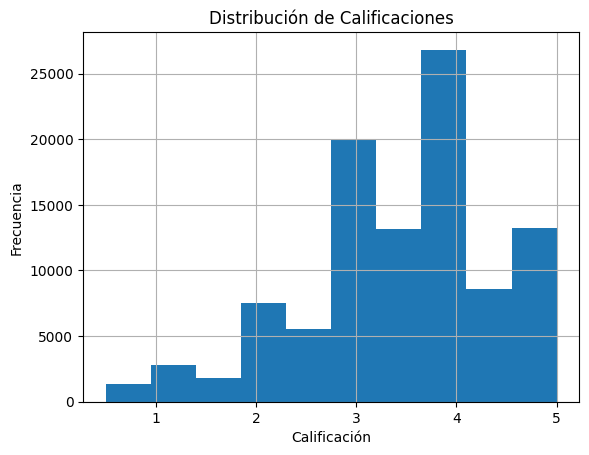

In [ ]:
# Histograma de las calificaciones
ratings_df['rating'].hist(bins=10)
plt.title("Distribución de Calificaciones")
plt.xlabel("Calificación")
plt.ylabel("Frecuencia")
plt.show()


### *¿Cuántas calificaciones han hecho los usuarios?*

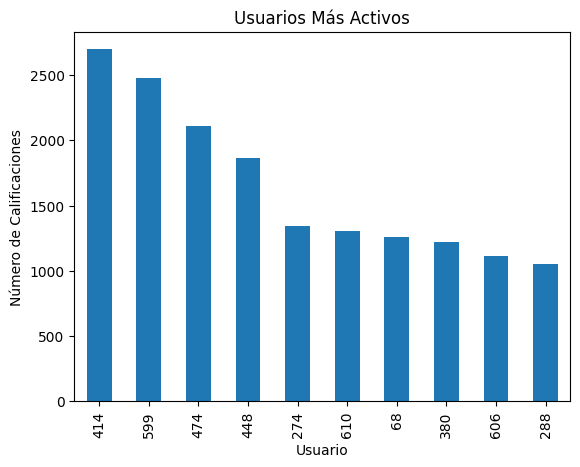

In [ ]:
# Ver usuarios más activos
top_users = ratings_df['userId'].value_counts().head(10)
top_users.plot(kind='bar')
plt.title("Usuarios Más Activos")
plt.xlabel("Usuario")
plt.ylabel("Número de Calificaciones")
plt.show()


Distribución de calificaciones (ratings):


In [ ]:
###distribución de calificaciones en la tabla ratings, es decir, cuántas veces se ha dado cada calificación (por ejemplo, cuántas veces se dio un 5, un 4, etc.).

pd.read_sql("""

SELECT
    rating,
    COUNT(*) AS count
FROM
    ratings
GROUP BY
    rating
ORDER BY
    rating DESC;""",con)

,rating,count
0,5.0,13211
1,4.5,8551
2,4.0,26818
3,3.5,13136
4,3.0,20047
5,2.5,5550
6,2.0,7551
7,1.5,1791
8,1.0,2811
9,0.5,1370


Calificación media por película

In [ ]:
###10 películas con las mejores calificaciones promedio
pd.read_sql("""
SELECT
    movieId,
    AVG(rating) AS average_rating
FROM
    ratings
GROUP BY
    movieId
ORDER BY
    average_rating DESC
LIMIT 10;

""",con)

,movieId,average_rating
0,187717,5.0
1,184245,5.0
2,179135,5.0
3,179133,5.0
4,176601,5.0
5,175431,5.0
6,175397,5.0
7,175387,5.0
8,175293,5.0
9,174551,5.0


In [ ]:
import os
import sys
import shutil



path='/content/drive/MyDrive/cod/marketing/MarketingprojectG8/data'
os.chdir(path)###volver la carpeta del repositorio directorio de trabajo
sys.path.append(path)### agregarla al path, para poder leer los archivos de funciones propios como paquetes

# Ruta de la base de datos copiada (new database file path)
#copied_path = '/content/drive/MyDrive/UdeA/MarketingBorrador/movies2'
#copied_path = '/content/drive/MyDrive/cod/marketing/MarketingprojectG8/data/movies2'


# Construcción la ruta completa al archivo de base de datos de origen
source_file = os.path.join(path, 'db_movies')

# Crear una copia de la base de datos
shutil.copy(source_file, copied_path)

# Verificar que se haya copiado la base de datos
print(f"Database copied from '{source_file}' to '{copied_path}'")
print(os.listdir())

Database copied from '/content/drive/MyDrive/cod/marketing/MarketingprojectG8/data/db_movies' to '/content/drive/MyDrive/UdeA/MarketingBorrador/movies2'
['db_movies', 'copied_path', 'movies2']


In [ ]:
# Conectar a la nueva base de datos copiada
con = sql.connect(copied_path)
cur= con.cursor()

# Consultar las tablas para verificar que la copia se realizó correctamente
cur.execute("SELECT name FROM sqlite_master WHERE type='table';")
tables = cur.fetchall()

print("Tablas en la base de datos copiada:")
for table in tables:
    print(table)

Tablas en la base de datos copiada:
('ratings',)
('movies',)


In [ ]:
# Importar tabla movies de sql a python

movies=pd.read_sql("SELECT * FROM movies",con)
movies.head()#vision general
movies.info()#tipo de cada variable
movies.duplicated().sum()#veriicar duplicados

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int64 
 1   title    9742 non-null   object
 2   genres   9742 non-null   object
dtypes: int64(1), object(2)
memory usage: 228.5+ KB


np.int64(0)

In [ ]:
# Importar tabla ratings de sql a python
ratings=pd.read_sql("SELECT * FROM ratings",con)

ratings.head()#vision general
ratings.info()#tipo de cada variable
ratings.duplicated().sum()#verificar duplicados

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


np.int64(0)

In [ ]:
# Verificar valores nulos.
print("Valores nulos en movies:")
print(movies.isnull().sum())

print("Valores nulos en ratings:")
print(ratings.isnull().sum())

Valores nulos en movies:
movieId    0
title      0
genres     0
dtype: int64
Valores nulos en ratings:
userId       0
movieId      0
rating       0
timestamp    0
dtype: int64


In [ ]:
# Cambiar el formato de timestamp por uno de fecha para hacer su manejo mas cómodo.
ratings['rating_time'] =pd.to_datetime(ratings['timestamp'], unit='s')
ratings.drop(columns=["timestamp"],inplace=True)
ratings.head()

,userId,movieId,rating,rating_time
0,1,1,4.0,2000-07-30 18:45:03
1,1,3,4.0,2000-07-30 18:20:47
2,1,6,4.0,2000-07-30 18:37:04
3,1,47,5.0,2000-07-30 19:03:35
4,1,50,5.0,2000-07-30 18:48:51


In [ ]:
#Llevamos la tabla a SQL

ratings.to_sql("ratings_dt",con,if_exists="replace",index=False)
pd.read_sql("""select * from ratings_dt""",con)

,userId,movieId,rating,rating_time
0,1,1,4.0,2000-07-30 18:45:03
1,1,3,4.0,2000-07-30 18:20:47
2,1,6,4.0,2000-07-30 18:37:04
3,1,47,5.0,2000-07-30 19:03:35
4,1,50,5.0,2000-07-30 18:48:51
...,...,...,...,...
100831,610,166534,4.0,2017-05-03 21:53:22
100832,610,168248,5.0,2017-05-03 22:21:31
100833,610,168250,5.0,2017-05-08 19:50:47
100834,610,168252,5.0,2017-05-03 21:19:12


In [ ]:
#separar generos en db movies
genres=movies['genres'].str.split('|')
te = TransactionEncoder()
genres = te.fit_transform(genres)
genres = pd.DataFrame(genres, columns = te.columns_)

In [ ]:
#extraemos año de estreno del titulo
movies['year'] = movies['title'].str.strip().str[-5:-1]

In [ ]:
#valores extraidos
movies['year'].unique()

array(['1995', '1994', '1996', '1976', '1992', '1967', '1993', '1964',
       '1977', '1965', '1982', '1990', '1991', '1989', '1937', '1940',
       '1969', '1981', '1973', '1970', '1955', '1959', '1968', '1988',
       '1997', '1972', '1943', '1952', '1951', '1957', '1961', '1958',
       '1954', '1934', '1944', '1960', '1963', '1942', '1941', '1953',
       '1939', '1950', '1946', '1945', '1938', '1947', '1935', '1936',
       '1956', '1949', '1932', '1975', '1974', '1971', '1979', '1987',
       '1986', '1980', '1978', '1985', '1966', '1962', '1983', '1984',
       '1948', '1933', '1931', '1922', '1998', '1929', '1930', '1927',
       '1928', '1999', '2000', '1926', '1919', '1921', '1925', '1923',
       '2001', '2002', '2003', '1920', '1915', '1924', '2004', '1916',
       '1917', '2005', '2006', '1902', 'lon ', '1903', '2007', '2008',
       '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016',
       '2017', '2018', '1908', 'r On', ' Roa', 'atso', 'imal', 'erso',
      

In [ ]:
# Filtrar películas sin año válido
movies_sin_año = movies[~movies['year'].str.contains('\d{4}', na=False)]

# Unir con ratings usando 'movieId' como clave
ratings_filtrados = pd.merge(ratings, movies_sin_año[['movieId']], on='movieId', how='inner')

# Calcular la cantidad de calificaciones por película
cantidad_calificaciones = ratings_filtrados.groupby("movieId").size()
cantidad_calificaciones

,0
movieId,
40697,2
140956,4
143410,1
147250,1
149334,1
156605,1
162414,1
167570,1
171495,2


In [ ]:
#poner en columna de año de estreno el valor "No_year" a peliculas sin año
#Funcion para remplazar valores de columna
def reemplazar_valor(valor):
  if valor in movies_sin_año.values:
      return "0"
  return valor
movies["year"]=movies['year'].apply(reemplazar_valor)

In [ ]:
# Crear una copia del dataframe 'movies' para evitar modificar el original
movies_genres = movies.copy()

# Iterar sobre las columnas de 'genres' y agregarlas a 'movies_split'
for column in genres.columns:
    movies_genres[column] = genres[column]

# Eliminar la columna 'genres' del dataframe 'movies_split'
movies_genres = movies_genres.drop(columns=['genres'])

In [ ]:
#Cargar a SQL
movies_genres.to_sql("movies_genres",con,if_exists="replace",index=False)
pd.read_sql("""select * from movies_genres""",con)

,movieId,title,year,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),1995,0,0,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
1,2,Jumanji (1995),1995,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,Grumpier Old Men (1995),1995,0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
3,4,Waiting to Exhale (1995),1995,0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
4,5,Father of the Bride Part II (1995),1995,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9737,193581,Black Butler: Book of the Atlantic (2017),2017,0,1,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
9738,193583,No Game No Life: Zero (2017),2017,0,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
9739,193585,Flint (2017),2017,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9740,193587,Bungo Stray Dogs: Dead Apple (2018),2018,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
#verificar categorias por errores tipograficos o categorias similares
#generos de peliculas
genres.columns.tolist()
#ratings
np.sort(ratings["rating"].unique()) #no hay calificaciones de 0

array([0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ])

In [ ]:
##Analisis de categorias
#se pretende saber si hay categorias que por su distribucion no aporten a los objetivos de la
#solucion y deban ser recortadas

# Obtiene una lista de todas las columnas de género
genre_cols = [col for col in movies_genres.columns if col not in ["title", "movieId", "year"]]

# Crea un diccionario para almacenar los conteos de género
genre_counts = {}

# Itera sobre las columnas de género y calcula el conteo de cada género
for genre in genre_cols:
    genre_counts[genre] = movies_genres[genre].sum()

# Crea un DataFrame a partir del diccionario de conteos de género
gen_total = pd.DataFrame(list(genre_counts.items()), columns=["Genre", "Qty"])

# Ordena el DataFrame por la columna 'Qty' en orden descendente
gen_total = gen_total.sort_values(by="Qty", ascending=False)

In [ ]:
fig = px.bar(gen_total,
             y='Genre',  # Géneros en el eje vertical
             x='Qty',    # Cantidad en el eje horizontal
             orientation='h',  # Barras horizontales
             title='Número de películas por género',
             labels={'Genre':'Género', 'Qty':'Cantidad de Películas'},
             color='Qty',  # Colorear las barras según la cantidad
             color_continuous_scale='Viridis') # Escala de colores
fig.show()

In [ ]:
gen_sum = pd.read_sql("""
SELECT
    SUM(Comedy) AS Qty_Comedy,
    SUM(Action) AS Qty_Action,
    SUM(Animation) AS Qty_Animation
FROM movies_genres
""", con)

gen_sum

,Qty_Comedy,Qty_Action,Qty_Animation
0,3756,1828,611


In [ ]:
# Consulta SQL para obtener la cantidad de calificaciones por usuario
rating_user= pd.read_sql("""
    SELECT userId AS User_Id,
           COUNT(*) AS Qty
    FROM ratings_dt
    GROUP BY userId
    ORDER BY Qty DESC;
""", con)

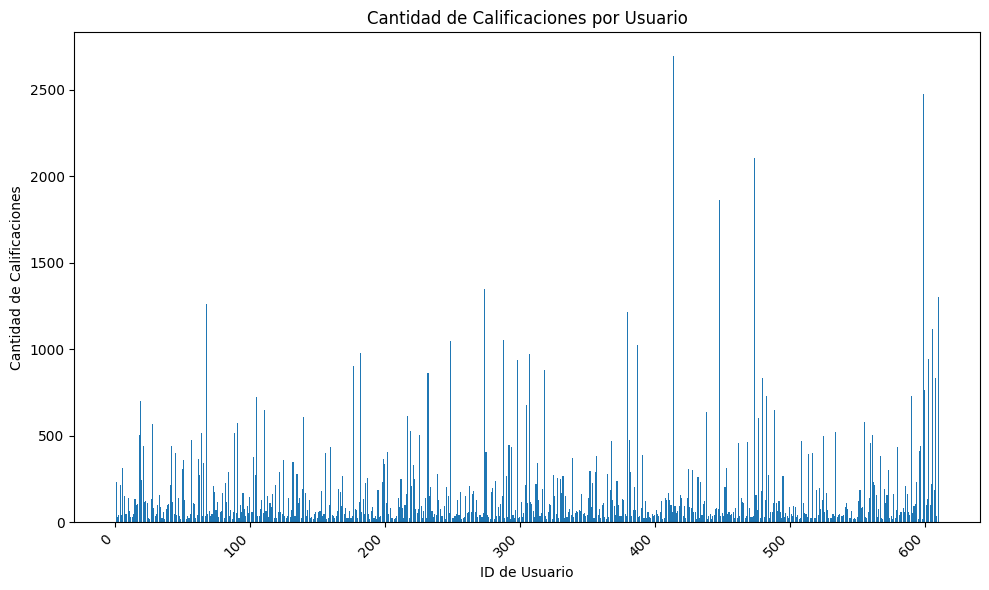

In [ ]:
# Crear el gráfico de barras
plt.figure(figsize=(10, 6))  # Ajustar el tamaño de la figura
plt.bar(rating_user['User_Id'], rating_user['Qty'])
plt.xlabel('ID de Usuario')
plt.ylabel('Cantidad de Calificaciones')
plt.title('Cantidad de Calificaciones por Usuario')
plt.xticks(rotation=45, ha='right')  # Rotar las etiquetas del eje x para mejor legibilidad
plt.tight_layout()  # Ajustar el diseño para evitar que las etiquetas se superpongan
plt.show()

In [ ]:
rating_user.describe()

,User_Id,Qty
count,610.000000,610.000000
mean,305.500000,165.304918
std,176.236111,269.480584
min,1.000000,20.000000
25%,153.250000,35.000000
50%,305.500000,70.500000
75%,457.750000,168.000000
max,610.000000,2698.000000


In [ ]:
date_range = pd.read_sql("""
    SELECT
        MIN(STRFTIME('%Y', rating_time)) AS año_min,
        MAX(STRFTIME('%Y', rating_time)) AS año_max,
        MAX(STRFTIME('%Y', rating_time)) - MIN(STRFTIME('%Y', rating_time)) AS rango_años
    FROM ratings_dt;
""", con)

# Acceder a los valores del DataFrame
min_year = date_range.loc[0, 'año_min']
max_year = date_range.loc[0, 'año_max']
year_range = date_range.loc[0, 'rango_años']

print(f"Minimum year: {min_year}")
print(f"Maximum year: {max_year}")
print(f"Year range: {year_range}")

Minimum year: 1996
Maximum year: 2018
Year range: 22


no vemos necesario eliminar usuarios, ya que el minimo de calificaciones por usuario es 20 que es un buen numero y solo un 25% de los usuarios tienen mas de 168 calificaciones, con datos atipicos que suben el promedio a 165 calificaciones por usuario. ademas vemos que el rango de las calificaciones es 22 años, tiempo en el cual un usuario puede calificar 2698 peliculas que es el valor maximo (aprox 10 peliculas mensuales)

In [ ]:
#cantidad de calificaciones por pelicula
rating_movie=pd.read_sql(''' select "movieId" as Movie_Id,
                         count(*) as Qty
                         from ratings_dt
                         group by "movieId"
                         order by Qty asc
                         ''',con )

In [ ]:
#Histograma
fig = px.histogram(
    rating_movie,
    x='Qty',
    title='Distribución de la Cantidad de Calificaciones por Película',
    nbins=20,
    labels={'Qty': 'Cantidad de Calificaciones'},
    color_discrete_sequence=['#66c2a6'],
)

fig.update_layout(
    xaxis_title='Cantidad de Calificaciones',
    yaxis_title='Frecuencia',
    font=dict(family='Arial', size=12),
    plot_bgcolor='#f0f0f0',
    bargap=0.05,
)

fig.show()

In [ ]:
rating_movie.describe()

,Movie_Id,Qty
count,9724.000000,9724.000000
mean,42245.024373,10.369807
std,52191.137320,22.401005
min,1.000000,1.000000
25%,3245.500000,1.000000
50%,7300.000000,3.000000
75%,76739.250000,9.000000
max,193609.000000,329.000000


no vemos necesario eliminar peliculas, la mitad de ellas tienen menos de 3 calificaciones y solo un 25% tienen mas de nuevo, con datos atipicos de un maximo de 329 calificaciones que elevan el promedio a 10 calificaciones por pelicula.

In [ ]:
# Análisis adicionales

# Número de usuarios que calificaron títulos.
unique_users_count = pd.read_sql("""
    SELECT COUNT(DISTINCT(userId)) AS cantidad_usuarios
    FROM ratings_dt
""", con)

# Acceder al valor del recuento
num_unique_users = unique_users_count.loc[0, 'cantidad_usuarios']

print(f"Número de usuarios únicos que calificaron películas: {num_unique_users}")

Número de usuarios únicos que calificaron películas: 610


In [ ]:
#tabla completa creada en sql
fn.ejecutar_sql('preprocesamiento.sql', cur)

cur.execute("select name from sqlite_master where type='table' ")
cur.fetchall()

#tabla completa
pd.read_sql("""select * from full_tabla""",con)

NameError: name 'fn' is not defined